# 1. Imports

In [18]:
import sys
import os

# Manually setting the path to the FGI project directory
project_path = 'C:\\Users\\laevitas\\Desktop\\Work\\fear-and-greed'
sys.path.append(os.path.abspath(project_path))

from src.utils import plot_series_analysis, corr_heatmap, adf_test, pairplot  # noqa: E402
from statsmodels.tsa.seasonal import seasonal_decompose  # noqa: E402
import plotly.graph_objs as go  # noqa: E402
from plotly.subplots import make_subplots  # noqa: E402
import matplotlib.pyplot as plt  # noqa: E402
from src.marketdata import FuturesData  # noqa: E402
from pprint import pprint  # noqa: E402

# 2. Data Collection, Feature Engineering & Aggregation

- collecting all BTC futures data from 2023-01-01 to 2024-10-08, daily data points
- feature extraction: expiry : parsed from the contract name in `currency` field
- feature engineering: days to expiration calculated as the difference between the `date` column and the `expiry` column 
- annualizing the basis: 
    $$
    \text{Annualized Basis} = \text{Basis} \times \frac{365}{\text{Days to Expiration}}
    $$
- aggregating `price` and `annualized_basis` by average and `volume` and `open_interest` by sum accross all the futures to get global figures
- only keeping the relevant fileds : `price`, `annualized_basis`, `open_interest`, and `volume`

In [19]:
coin = "btc"
start = "2023-01-01"
end = "2024-10-08"

futures = FuturesData(coin, start, end)

# 3. Data Cleaning

- cleaned the data using z score winsoritation method with a threshold of 3.0 accross all the columns

In [20]:
cleaned_futures = futures.copy().z_score_cleaning()

# 4. Exploratory Data Analysis

## 4.1. Descriptive Statistics

In [21]:
cleaned_futures.historical_data.describe()

,price,annualized_basis,open_interest,volume
count,647.000000,647.000000,6.470000e+02,6.470000e+02
mean,39034.434994,15.492577,4.668346e+09,1.548046e+09
std,16523.511302,18.920193,5.209774e+09,1.985097e+09
min,16512.461250,-59.335927,5.457682e+08,5.130412e+07
25%,24040.683750,5.071163,7.294035e+08,3.001732e+08
50%,33053.706250,11.837660,1.130746e+09,5.655764e+08
75%,56788.713333,21.724386,1.058202e+10,2.031370e+09
max,69580.733333,92.085988,1.448445e+10,7.853622e+09


### 4.1.1. Price Volatility

  The **average** price of **$39,034.43** indicates a significant market presence and trading activity within the Bitcoin futures market. On the other hand, the **high standard deviation** of **$16,523.51** underscores the inherent volatility of Bitcoin, which is crucial for futures traders looking to capitalize on price fluctuations.


### 4.1.2. Annualized Basis

With an **average** annualized basis of **15.49**, Bitcoin futures are generally trading at a premium over the spot price, which may signal bullish market sentiment. However, the substantial **range** from a **minimum of -59.34** to a **maximum of 92.09** indicates that market conditions can shift dramatically, affecting traders' strategies and potential profits.

### 4.1.3. Open Interest

The **mean** open interest of **4.67 billion** reflects a robust commitment from traders in the Bitcoin futures market, suggesting that many positions are being held over time. But, the **high standard deviation** of **5.21 billion** shows that there can be significant changes in market engagement, which may coincide with major news events or shifts in market sentiment.

### 4.1.4. Volume Trends

The **average** trading volume of **1.55 billion** indicates a highly active market, vital for liquidity and price discovery. Yet, the large variability in volume (**standard deviation of 1.99 billion**) indicates that trading activity can surge or dip sharply, providing insights into trader behavior during different market conditions.

## 4.2. Correlation Analysis

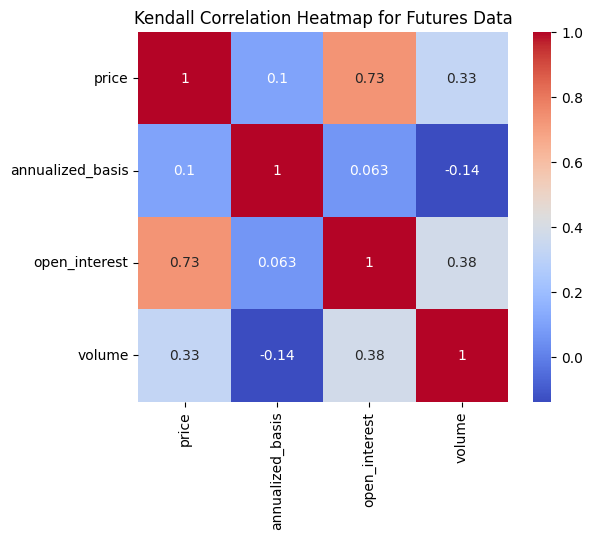

In [22]:
corr_heatmap(
    cleaned_futures.historical_data, "Kendall Correlation Heatmap for Futures Data"
)

The correlation heatmap shows the following observations:

1. **Strong Positive Correlation between Price and Open Interest (0.73):** 

   A **strong positive correlation** indicates that price increases are associated with higher open interest. This suggests that when prices rise, more positions are opened in the futures market, which may signal **greed** or bullish sentiment as traders expect further upward movement.

2. **Moderate Positive Correlation between Volume and Open Interest (0.38) and Price (0.33):** 

   A **moderate positive correlation** between **volume** and **prices** means that rising prices tend to coincide with increased trading volume, reflecting market engagement during price rallies. This could also indicate **greed**, as traders react to upward price trends by increasing their activity. Also, the **moderate positive correlation** between **volume** and **open interest** implies that as more positions are opened, trading volume also rises. This could reflect an increasing number of market participants or larger trades during periods of higher market engagement, again, signaling **greed**.

3. **Weak Correlation between Annualized Basis and Other Variables:** 
   
   **Weak correlations** with **price (0.10)**, **open interest (0.063)**, and **volume (-0.14)** suggest that the **annualized basis** is not strongly driven by these factors in this dataset. This may signal that the basis may be influenced by more complex market conditions and containing insights on long-term market sentiment trends.

These observations will have some implications on the index, such as:

- The strong correlation between price and open interest suggests that when constructing the Fear & Greed Index, the **open interest** metric should be weighted heavily in the features related to futures, as it reflects a big chunk of trader sentiment. Increased open interest alongside rising prices can signal strong bullish sentiment, which aligns with a "greed" phase in the index.

- The moderate correlation between **price** and **volume** reflects heightened activity during price rallies, further supporting the inclusion of trading volume as a support variable and a greed indicator.

- The weak relationships with the **annualized basis** suggest it may not provide clear insights into short-term trading behaviors. However, understanding its dynamics can still be useful for longer-term trend analysis, especially if sudden changes in the basis **trend** (if there is any) are observed like turning points.

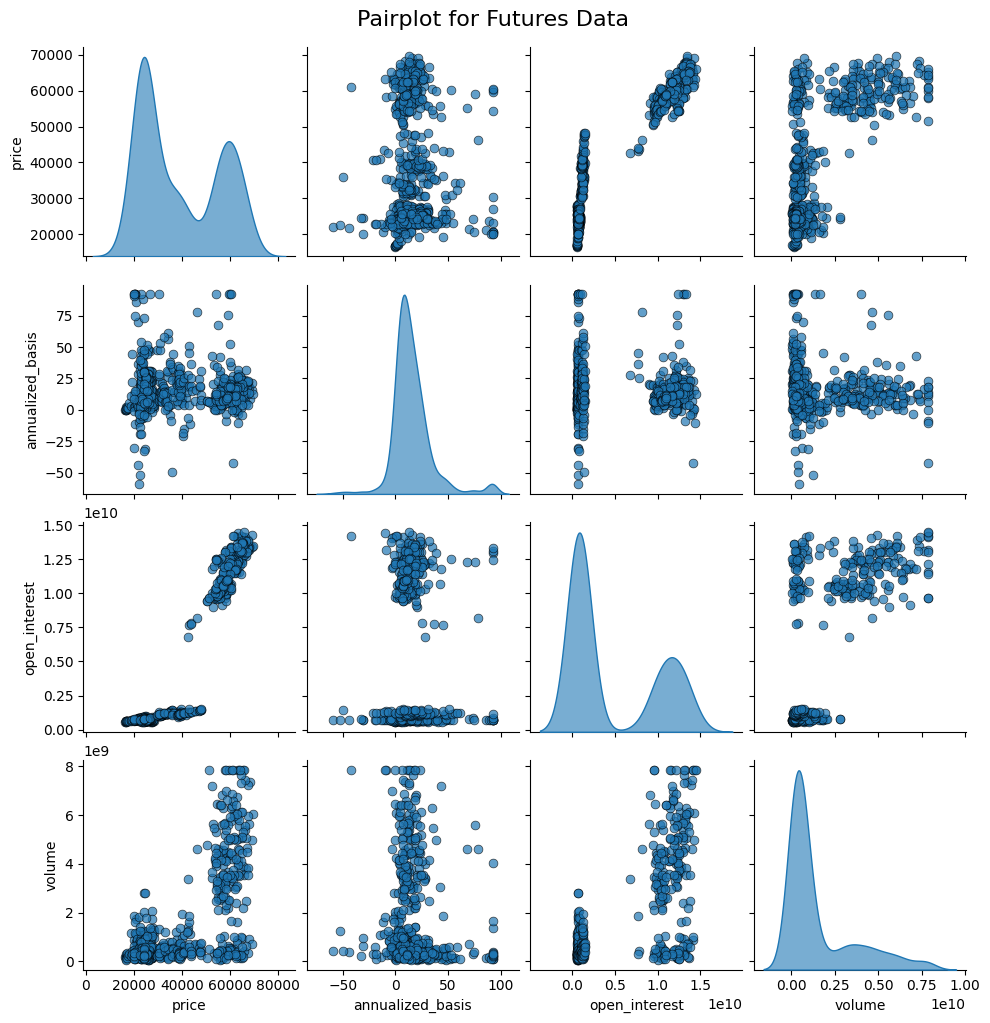

In [23]:
pairplot(cleaned_futures.historical_data, "Pairplot for Futures Data")

### Key Observations from the Pairplot:

1. **Price Distribution:**
   - The **price** distribution shows a bimodal distribution with peaks around **$30,000** and **$60,000**. This indicates two significant price levels where trading activity is concentrated, which could be indicative of market sentiment changes at these levels.
   - The wide spread of prices suggests periods of high volatility and potential shifts in market sentiment, which is critical to monitor for your Fear & Greed Index.

2. **Annualized Basis Relationships:**
   - The **annualized basis** distribution is highly concentrated around **zero**, with a few extreme values, indicating that most of the time, the basis is stable, but there can be notable deviations.
   - The scatter plots involving the annualized basis show no clear linear relationship with price or volume, supporting the weak correlations observed in the heatmap. This suggests that while the basis can fluctuate, it does not consistently drive price or volume movements.

3. **Open Interest Trends:**
   - The **open interest** scatter plot against **price** shows a clustering of points, particularly with prices in the **$30,000** to **$60,000** range. This supports the strong positive correlation observed previously, indicating that as prices increase, the number of open contracts tends to rise.
   - The open interest appears to have a more pronounced spread when volumes are higher, suggesting that market participation (in terms of open positions) is greater during periods of higher activity.

4. **Volume Analysis:**
   - The **volume** distribution shows a right-skewed pattern, indicating that most days have lower trading volume, with a few days experiencing very high volume.
   - The scatter plots between volume and the other variables reveal no strong linear relationships, but some points suggest increased volume might correlate with specific price ranges. This suggests that high trading activity can coincide with market movements at certain price levels.

### Implications for the Fear & Greed Index:

- **Price Levels as Sentiment Indicators:**
  - The bimodal distribution of price indicates key psychological price levels that could be integrated into your index. Monitoring trading sentiment around these levels could yield insights into market greed (buying pressure) or fear (selling pressure).

- **Open Interest as a Bullish Indicator:**
  - Given the strong correlation between open interest and price, consider using open interest as a major component of your index. A rise in open interest during price increases can signal a strong bullish sentiment.

- **Volume's Role in Market Activity:**
  - Although volume does not show strong correlations with price or open interest, it can serve as a supporting metric. High volume, especially when combined with significant price movements, can indicate increased market participation and confidence, aligning with market sentiment.

- **Annualized Basis as Contextual Information:**
  - Despite showing weak correlations with other variables, the annualized basis can still provide valuable context for market conditions. Sudden spikes in the basis could indicate changing sentiment and warrant closer monitoring.

### Conclusion:
The pairplot reinforces some of the insights gained from the previous analyses, particularly regarding the importance of open interest and price levels in assessing market sentiment. By incorporating these observations into your Fear & Greed Index, you can create a more nuanced view of market behavior and sentiment dynamics.

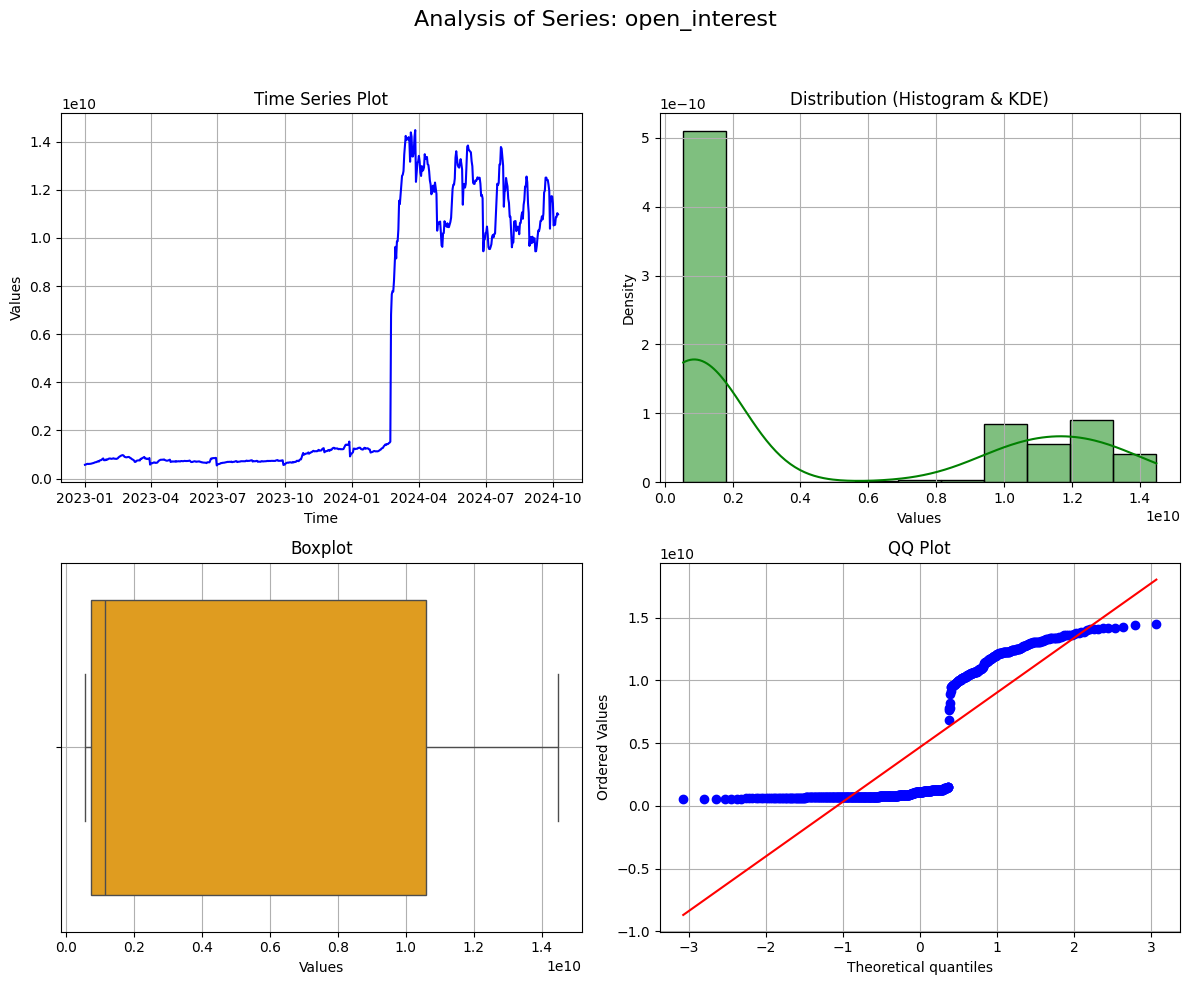

In [24]:
plot_series_analysis(cleaned_futures.historical_data["open_interest"])

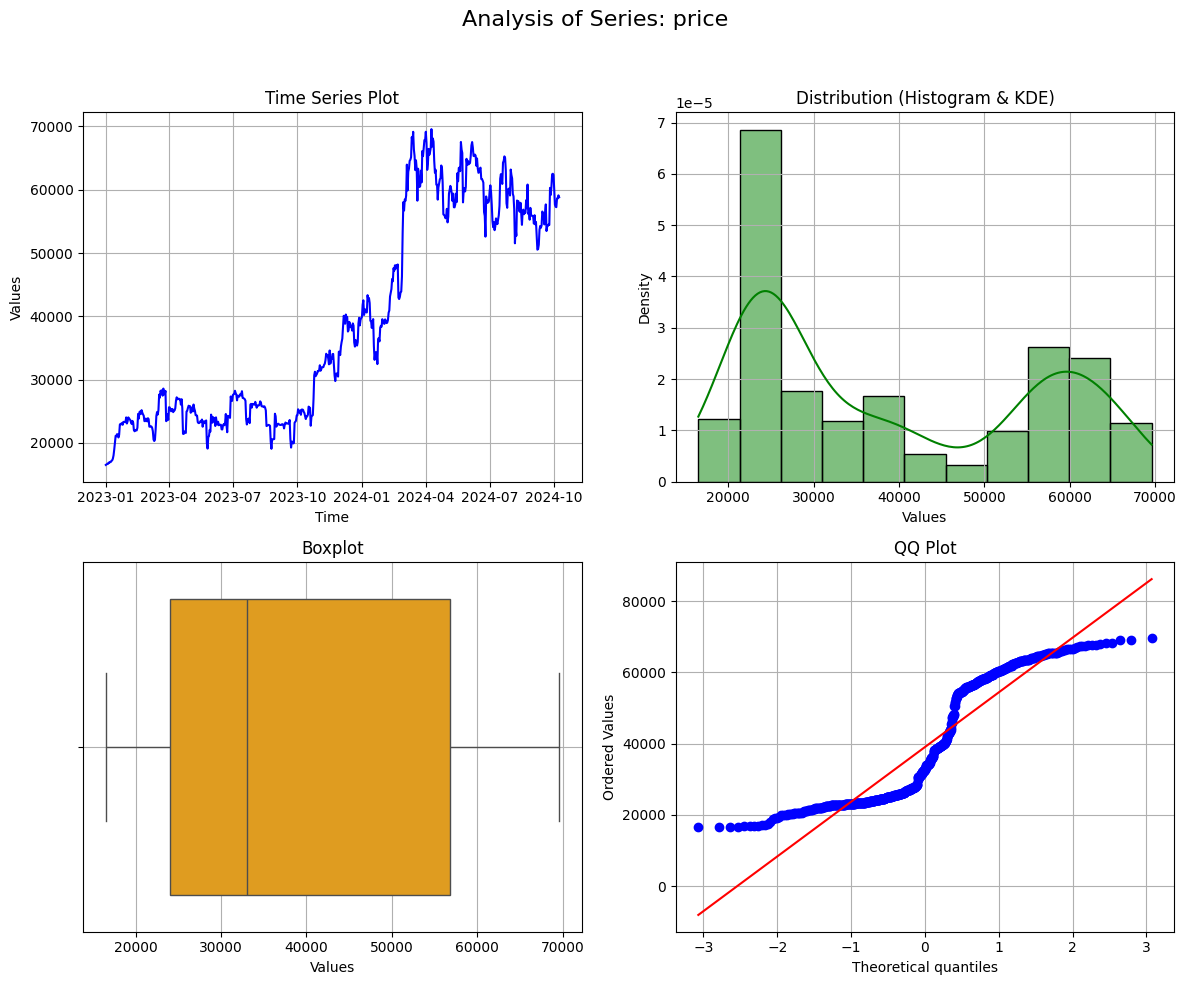

In [25]:
plot_series_analysis(cleaned_futures.historical_data["price"])

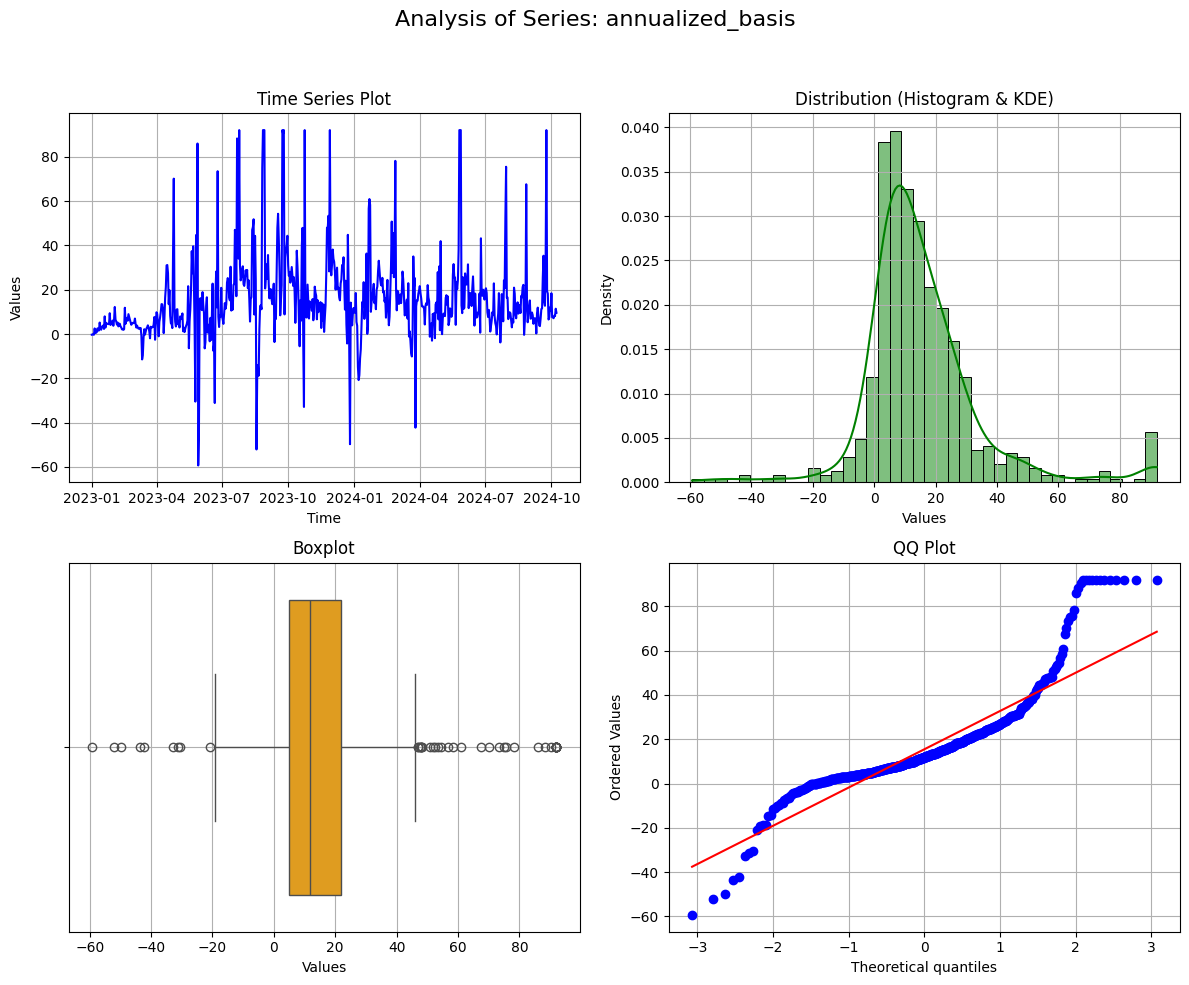

In [26]:
plot_series_analysis(cleaned_futures.historical_data["annualized_basis"])

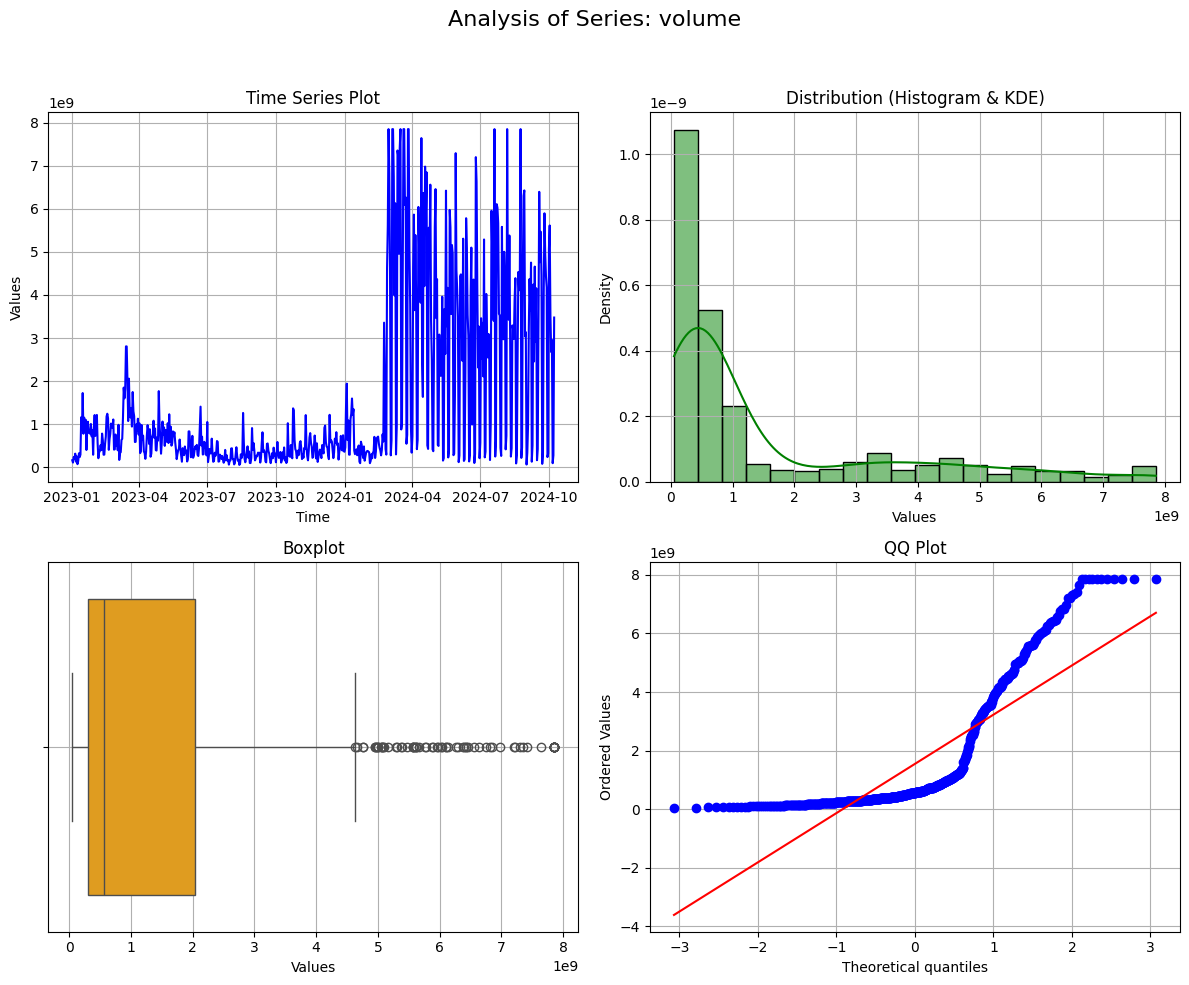

In [27]:
plot_series_analysis(cleaned_futures.historical_data["volume"])

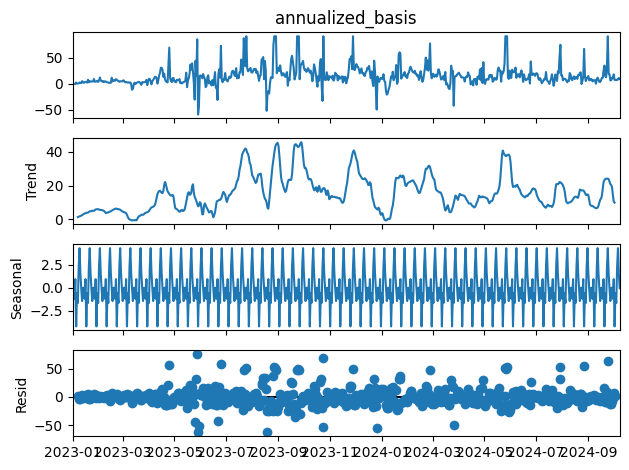

In [28]:
result = seasonal_decompose(
    cleaned_futures.historical_data["annualized_basis"], model="additive", period=12
)
result.plot()
plt.show()

In [40]:
def signal_decomp(data, period: int = 10, return_results: bool = False):
    result = seasonal_decompose(
        data,
        model="additive",
        period=period,
    )

    fig = make_subplots(rows=1, cols=1)

    fig.add_trace(
        go.Scatter(
            x=data.index,
            y=result.seasonal + result.trend,
            mode="lines",
            name="Trend + Seasonal",
        )
    )

    fig.add_trace(
        go.Scatter(
            x=data.index,
            y=data,
            mode="lines",
            name="Original Data",
        )
    )

    fig.add_trace(
        go.Scatter(
            x=data.index,
            y=result.resid,
            mode="lines",
            name="Residuals",
        )
    )

    fig.add_trace(
        go.Scatter(
            x=data.index,
            y=result.trend,
            mode="lines",
            name="Trend",
        )
    )

    fig.add_trace(
        go.Scatter(
            x=data.index,
            y=result.seasonal,
            mode="lines",
            name="Seasonal",
        )
    )

    fig.update_layout(
        title=f"Signal Decomposition of: {data.name}",
        xaxis_title="Date",
        yaxis_title="Annualized Basis",
        legend_title="Components",
        showlegend=True,
    )

    fig.show()

    if return_results:
        return result

In [38]:
# Decompose the time series
result = seasonal_decompose(
    cleaned_futures.historical_data["annualized_basis"],
    model="additive",
    period=10,
)

# Create the figure with subplots
fig = make_subplots(rows=1, cols=1)

# Add the decomposed signal (sum of seasonal, trend, and residual)
fig.add_trace(
    go.Scatter(
        x=cleaned_futures.historical_data.index,
        y=result.seasonal + result.trend,
        mode="lines",
        name="Trend + Seasonal",
    )
)

# Add the original time series data
fig.add_trace(
    go.Scatter(
        x=cleaned_futures.historical_data.index,
        y=cleaned_futures.historical_data["annualized_basis"],
        mode="lines",
        name="Original Data",
    )
)

# Add residuals
fig.add_trace(
    go.Scatter(
        x=cleaned_futures.historical_data.index,
        y=result.resid,
        mode="lines",
        name="Residuals",
    )
)

# Add seasonal component
fig.add_trace(
    go.Scatter(
        x=cleaned_futures.historical_data.index,
        y=result.seasonal,
        mode="lines",
        name="Seasonal",
    )
)

# Add trend component
fig.add_trace(
    go.Scatter(
        x=cleaned_futures.historical_data.index,
        y=result.trend,
        mode="lines",
        name="Trend",
    )
)

# Update layout
fig.update_layout(
    title=f"Signal Decomposition of: {cleaned_futures.historical_data['annualized_basis'].name}",
    xaxis_title="Date",
    yaxis_title="Annualized Basis",
    legend_title="Components",
    showlegend=True,
    # grid=dict(show=True)
)

# Show the plot
fig.show()

In [41]:
signal_decomp(cleaned_futures.historical_data['annualized_basis'])

In [30]:

adf_result = adf_test(futures.historical_data["annualized_basis"])
pprint(adf_result)

The time series is stationary (reject the null hypothesis).
{'ADF Statistic': -9.132496656654451,
 'Critical Values': {'1%': -3.440560883168159,
                     '10%': -2.569169329058723,
                     '5%': -2.8660454146233434},
 'p-value': 2.995810725143695e-15,
 'regression': 'c'}
